In [1]:
import numpy as np 
import scanpy as sc 
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns 
import anndata as ad 
import scanpy.external as sce 

def count_summary(neuron, key_1 , key_2 = 'samples'):
        anno_df = neuron.obs.copy()
        anno_df.head()

        df = anno_df 
        # 1. 按col1和col2分组，统计每个组合的数量
        grouped = df.groupby([key_1, key_2]).size().reset_index(name='count')

        # 2. 按col1分组，计算总数
        total_counts = df.groupby(key_2).size().reset_index(name='total_count')

        # 3. 合并数据，计算比例
        merged = grouped.merge(total_counts, on=key_2)
        merged['proportion'] = merged['count'] #/ merged['total_count']

        # 4. 重新排序和格式化结果
        result = merged[[key_2, key_1, 'proportion']]

        result = result.pivot(index=key_1, columns=key_2, values='proportion')
        return result


In [2]:
scdata = sc.read_h5ad('final_hvg.h5ad')
scdata

AnnData object with n_obs × n_vars = 26222 × 2670
    obs: 'species', 'tissues', 'samples', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cluster', 'celltype', 'coarse_celltype', 'eco'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'eco_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'species_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

d:\Anaconda\envs\scanpy-1.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


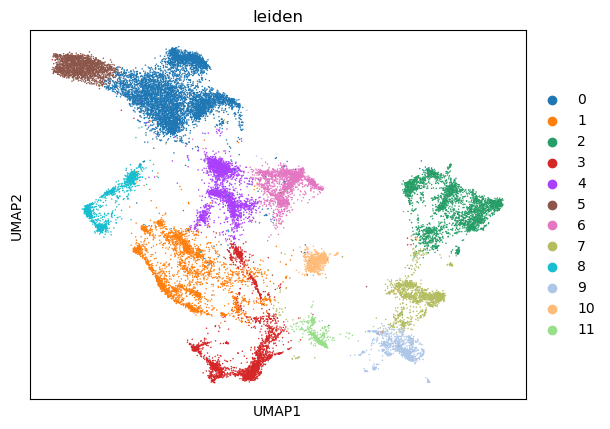

In [3]:
sc.tl.umap(scdata, min_dist = 0.1)
sc.pl.umap(scdata, color = 'leiden')

In [5]:
count_summary(scdata, 'leiden', 'species')

C:\Users\sunrui\AppData\Local\Temp\ipykernel_120488\817895412.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([key_1, key_2]).size().reset_index(name='count')
C:\Users\sunrui\AppData\Local\Temp\ipykernel_120488\817895412.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby(key_2).size().reset_index(name='total_count')


species    CY    JT    M   QF     T
leiden                             
0        1446  1422    0    0  3359
1         973  1146  257  559   237
2        1017   892  214  711   291
3          12   252  646  667   880
4        1210  1037    0    0   116
5           0    10  899  412   673
6         817   903   34   12    75
7         306   528  186  108   210
8         686   592    6   17    33
9         203   234  139  196   333
10         53    38  302   23   265
11          0     5  158  151   271

## 导入全部注释

In [11]:
all_anno = sc.read_h5ad(r'D:\sly_data\差异cluster_主图\scdata_model_anno.h5ad')
all_anno_obs = all_anno.obs.copy()

new_index = []
for ele in scdata.obs.index.values:
    a,b = ele.split('HM-')
    new_index.append(a.lower() + '_' + b) 
scdata.obs.index = np.array(new_index)

mutual_idx = np.intersect1d(all_anno_obs.index.values, scdata.obs.index.values)
print(mutual_idx.shape)


(26222,)


In [21]:
scdata = scdata[mutual_idx,:]
all_anno_obs = all_anno_obs.loc[mutual_idx, :]
assert (scdata.obs.index == all_anno_obs.index).all()


scdata.obs.loc[:,'pred_class'] = all_anno_obs.loc[:,'pred_class'].values
scdata.obs.loc[:,'pred_label'] = all_anno_obs.loc[:,'pred_label'].values
scdata.obs.loc[:,'pred_neighborhood'] = all_anno_obs.loc[:,'pred_neighborhood'].values 

C:\Users\sunrui\AppData\Local\Temp\ipykernel_120488\3270381071.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['L4/5 IT CTX', 'CA3', 'L4/5 IT CTX', 'L4/5 IT CTX', 'CA3', ..., 'DG', 'CA1-ProS', 'DG', 'DG', 'DG']
Length: 26222
Categories (51, object): ['Astro', 'CA1', 'CA1-ProS', 'CA2-IG-FC', ..., 'Sst', 'Sst Chodl', 'VLMC', 'Vip']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  scdata.obs.loc[:,'pred_label'] = all_anno_obs.loc[:,'pred_label'].values
d:\Anaconda\envs\scanpy-1.10\lib\site-packages\pandas\core\indexing.py:1857: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value


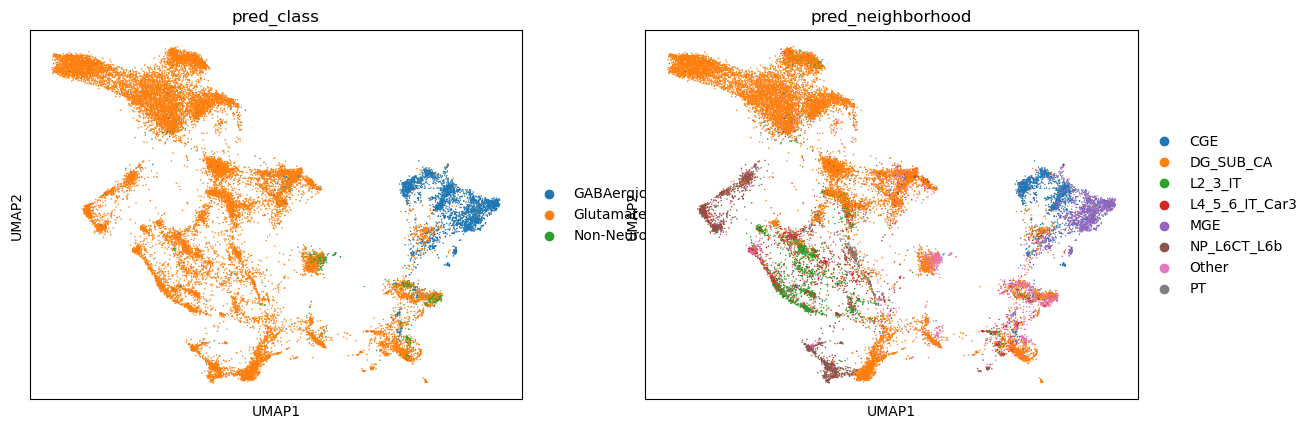

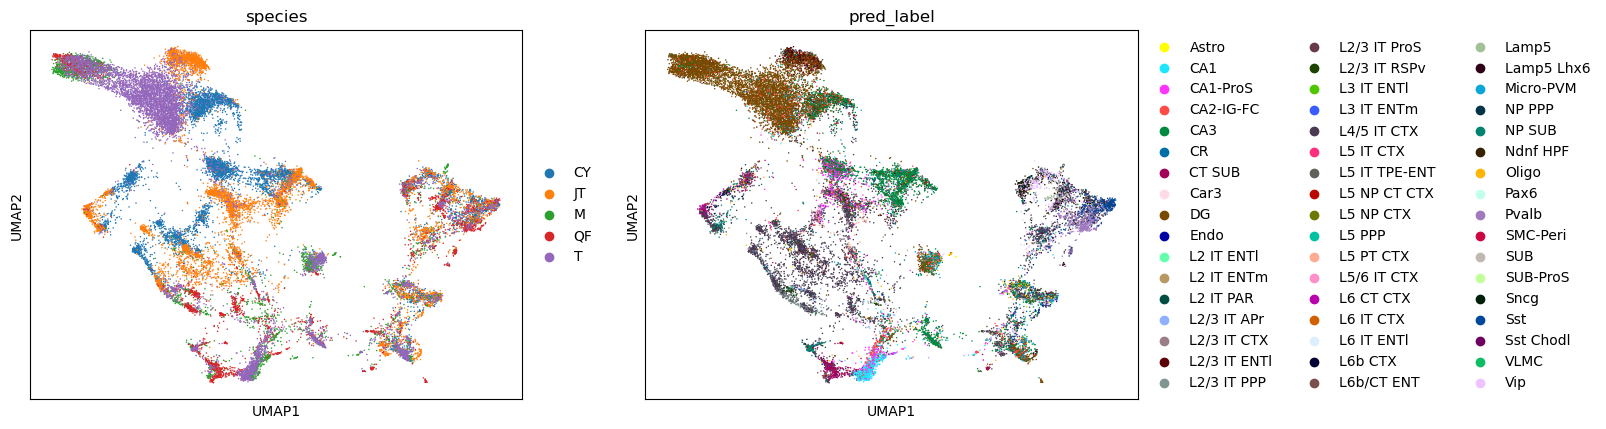

In [24]:
sc.pl.umap(scdata, color = ['pred_class', 'pred_neighborhood'])
sc.pl.umap(scdata, color = ['species', 'pred_label'])

In [37]:
scdata.obs.loc[:,'celltype_vis'].value_counts()

celltype_vis
DG              6621
L4/5 IT CTX     5198
CA3             3898
CA1-ProS         972
CA2-IG-FC        884
L2/3 IT ENTl     740
CA1              708
Pvalb            703
Vip              588
Sst              571
CT SUB           541
L2 IT PAR        454
Ndnf HPF         421
NP SUB           420
L2/3 IT PPP      374
Micro-PVM        348
Sncg             317
L5 PT CTX        273
CR               259
L6b/CT ENT       238
Oligo            219
L6 CT CTX        180
L2/3 IT APr      153
unclear          143
L6b CTX          130
L2/3 IT CTX      114
Lamp5            112
L2/3 IT RSPv     102
Car3             102
Endo              82
Lamp5 Lhx6        76
L5 PPP            59
L2/3 IT ProS      52
L6 IT ENTl        36
Sst Chodl         36
Astro             34
NP PPP            32
L2 IT ENTm        32
Name: count, dtype: int64

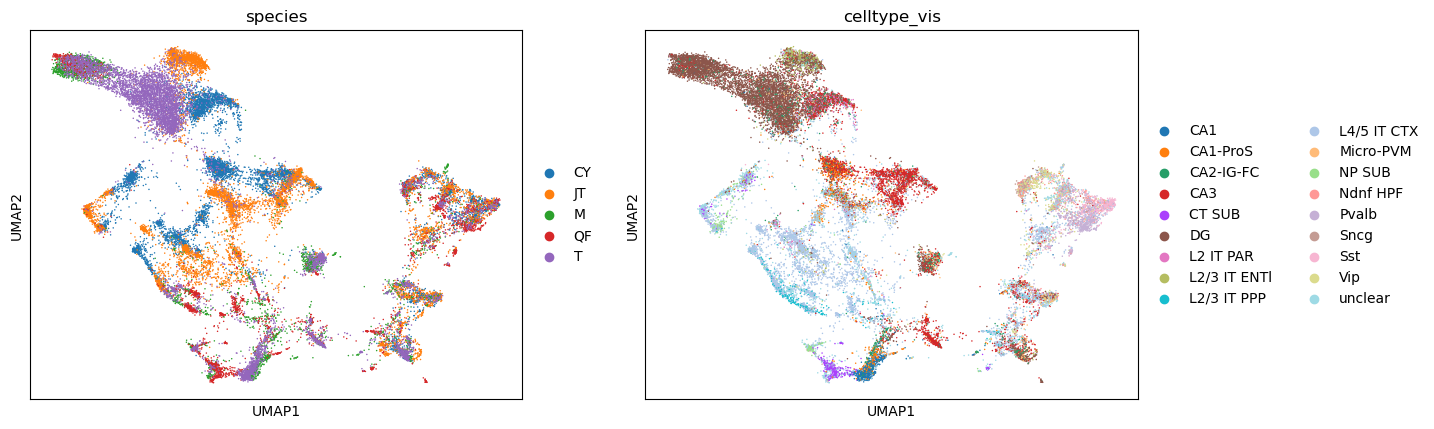

In [38]:
scdata.obs.drop(columns = 'celltype_vis', inplace = True)
del scdata.uns['celltype_vis_colors']

pred_class_label = scdata.obs.loc[:,'pred_label'].values 
#pred_class = mhm_anno.iloc[:,10:]

#for ele in np.argmax(pred_class.values, axis = 1):
#    pred_class_label.append(pred_class.columns[ele])
scdata.obs.loc[:,'pred_label'] = pred_class_label

coarse_dic = {}
for celltype, counts in scdata.obs.pred_label.value_counts().items():
    if counts >= 300:
        coarse_dic[celltype] = celltype
    else: 
        coarse_dic[celltype] = 'unclear'
scdata.obs.loc[:,'celltype_vis'] = scdata.obs.pred_label.map(coarse_dic)

sc.pl.umap(scdata, color = ['species', 'celltype_vis'])

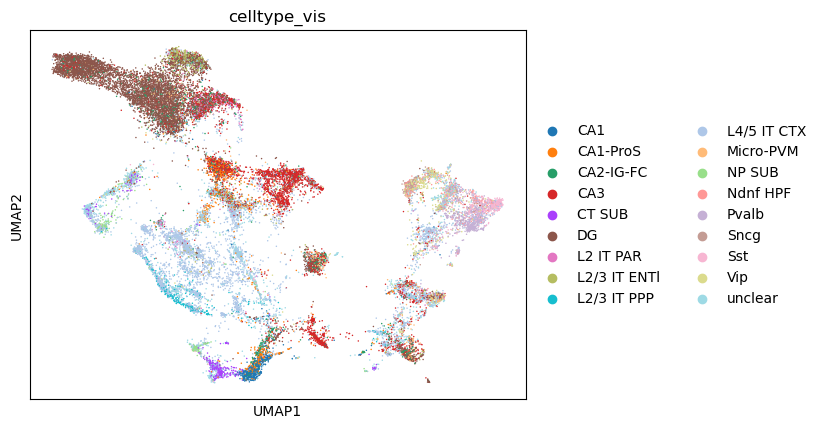

In [40]:
sc.pl.umap(scdata, color = ['celltype_vis'])

C:\Users\sunrui\AppData\Local\Temp\ipykernel_120488\3477265096.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(scdata, resolution= 0.2, restrict_to=['leiden',['3']])


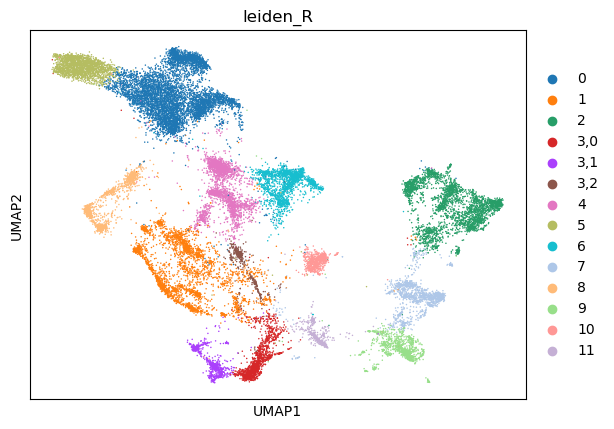

C:\Users\sunrui\AppData\Local\Temp\ipykernel_120488\817895412.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([key_1, key_2]).size().reset_index(name='count')
C:\Users\sunrui\AppData\Local\Temp\ipykernel_120488\817895412.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby(key_2).size().reset_index(name='total_count')


species          CY    JT     M   QF     T
pred_label                                
Astro             4     1    15    8     6
CA1              12    12   312    9   363
CA1-ProS        492   197    27   52   204
CA2-IG-FC       250   104    16   13   501
CA3            2095   924   120  149   610
CR              179     9    11   14    46
CT SUB           99    36    45  330    31
Car3             25    76     0    1     0
DG              386   555  1388  439  3853
Endo             42    32     1    2     5
L2 IT ENTl        0     2     0    0     0
L2 IT ENTm       14    15     0    3     0
L2 IT PAR       325   119     0    3     7
L2/3 IT APr       2     1   118    1    31
L2/3 IT CTX       2    94     7    1    10
L2/3 IT ENTl      9   730     0    1     0
L2/3 IT PPP      38    30   139  117    50
L2/3 IT ProS      4    25    20    0     3
L2/3 IT RSPv      0     0    68    9    25
L3 IT ENTl        0     7     0    0     0
L3 IT ENTm        0     1     1    0     0
L4/5 IT CTX    1177  3057    33  772   159
L5 IT CTX         0     0     0    0     0
L5 IT TPE-ENT     0     0     1    0     0
L5 NP CT CTX      0     0     3    3     1
L5 NP CTX         2     7     6    8     2
L5 PPP            1     0    23    6    29
L5 PT CTX        77   184     2    8     2
L5/6 IT CTX       0    14     0    0     0
L6 CT CTX        41   119     7   10     3
L6 IT CTX         0    15     4    0     2
L6 IT ENTl        6    30     0    0     0
L6b CTX          42    83     2    3     0
L6b/CT ENT      111    11    62   22    32
Lamp5            15    28    16   46     7
Lamp5 Lhx6       27     2    18    9    20
Micro-PVM         3     6    94    3   242
NP PPP            0     0    28    0     4
NP SUB          223    36    18   86    57
Ndnf HPF        280    63     4   46    28
Oligo            75     4    48   11    81
Pax6              7    14     1    0     0
Pvalb           151   136    24  320    72
SMC-Peri          3     0     1    0     2
SUB               0     0    11    1     0
SUB-ProS          9     4     7    1     1
Sncg            105   142    15   46     9
Sst             225    66    37  133   110
Sst Chodl        24     6     0    4     2
VLMC              1     1     0    0     0
Vip             140    61    88  166   133

In [39]:
sc.tl.leiden(scdata, resolution= 0.2, restrict_to=['leiden',['3']])
sc.pl.umap(scdata, color = 'leiden_R')

count_summary(scdata, 'pred_label', 'species')

CY


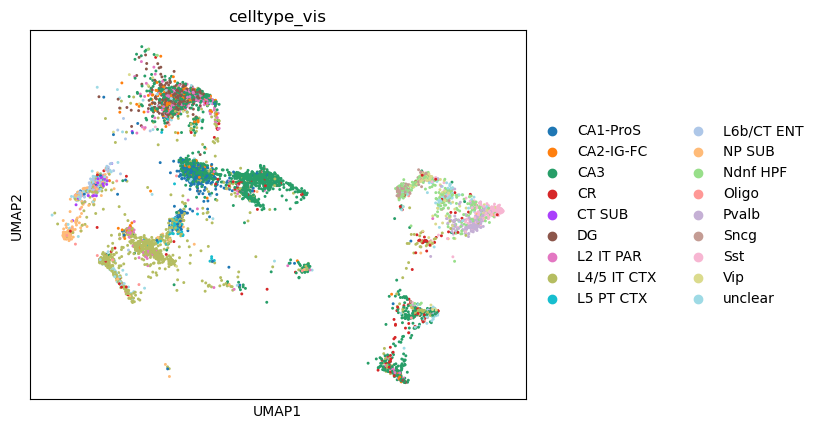

JT


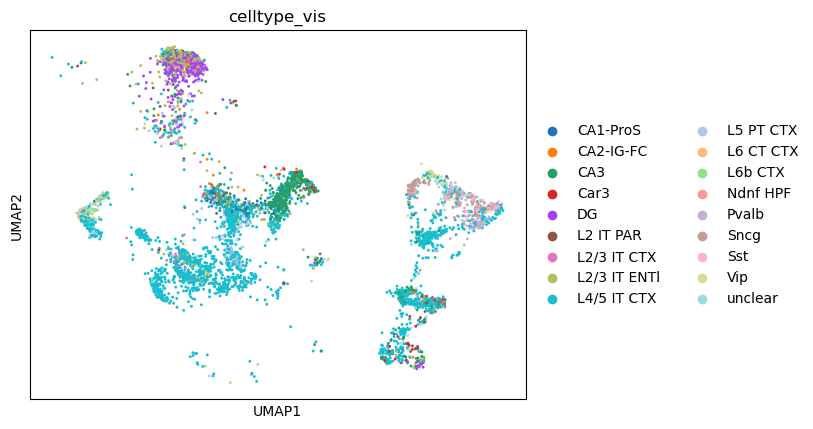

M


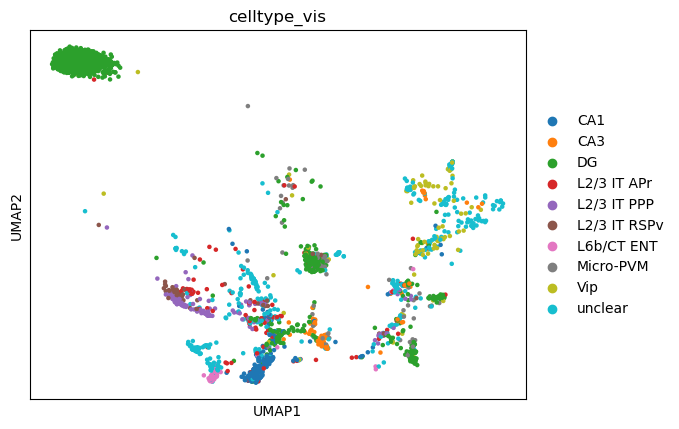

QF


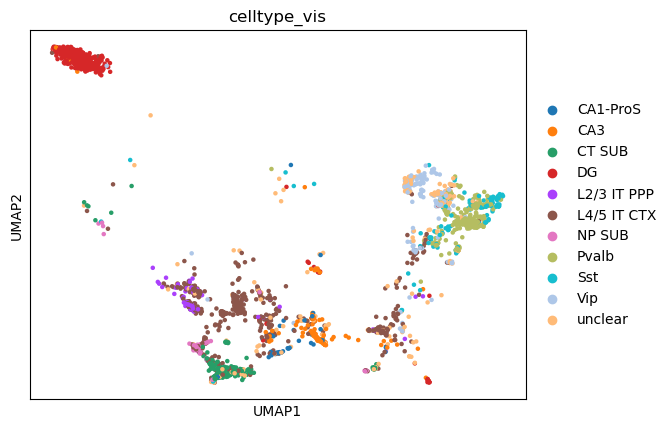

T


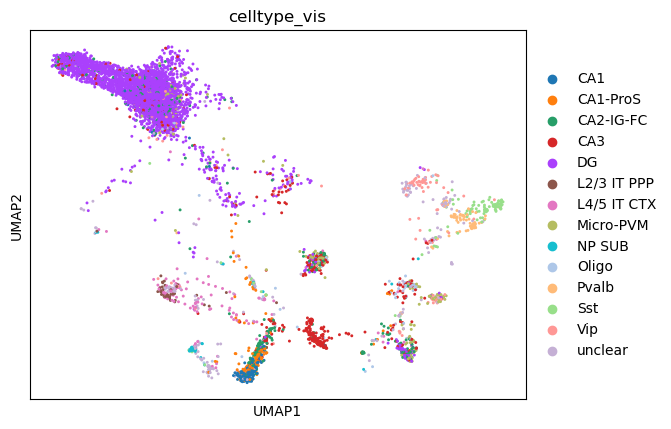

In [58]:
for ele in scdata.obs.species.unique():
    subdata = scdata[scdata.obs.species == ele]
    print(ele)
    subdata.obs.drop(columns = 'celltype_vis', inplace = True)
    del subdata.uns['celltype_vis_colors']
    pred_class_label = subdata.obs.loc[:,'pred_label'].values.astype(object)
    subdata.obs.loc[:,'pred_label'] = pred_class_label

    coarse_dic = {}
    for celltype, counts in subdata.obs.pred_label.value_counts().items():
        if counts >= 50:
            coarse_dic[celltype] = celltype
        else: 
            coarse_dic[celltype] = 'unclear'
    subdata.obs.loc[:,'celltype_vis'] = subdata.obs.pred_label.map(coarse_dic)

    
    

    pred_class_label = subdata.obs.loc[:,'pred_label'].values.astype(str)
    subdata.obs['pred_label'] = subdata.obs['pred_label'].astype('object')

    sc.pl.umap(subdata, color = ['celltype_vis'])

### 导入小鼠注释

In [9]:
mdata = scdata[scdata.obs.species =='M']
print(mdata.shape)

mhm_anno = pd.read_csv('allen_21_mhm_anno.csv', index_col= 'Unnamed: 0')
#mhm_anno = pd.read_csv('mhm_anno.csv', index_col= 'Unnamed: 0')
mhm_anno.index = 'MHM-' +  mhm_anno.index.values.astype(object)
mutual_idx = np.intersect1d(mhm_anno.index.values, mdata.obs.index.values)
print(mutual_idx.shape)

mdata = mdata[mutual_idx]
mhm_anno = mhm_anno.loc[mutual_idx]

(2841, 2670)
(2841,)


In [10]:
mhm_anno

n_genes     pred_class    pred_label  celltype_vis  \
MHM-AAACAGCCAAGTCGCT-1     4152  Glutamatergic           CA1           CA1   
MHM-AAACAGCCACTAAATC-1     2989  Glutamatergic            DG            DG   
MHM-AAACAGCCATCAGCAC-1     1949  Glutamatergic            DG            DG   
MHM-AAACATGCAGGTTACC-1     2599  Glutamatergic  L2/3 IT RSPv  L2/3 IT RSPv   
MHM-AAACCAACATCCAGGT-1     2631  Glutamatergic   L2/3 IT APr   L2/3 IT APr   
...                         ...            ...           ...           ...   
MHM-TTTGTGAAGGCCATCA-1     1897  Glutamatergic        CT SUB        CT SUB   
MHM-TTTGTGGCACCCACAG-1     3430  Glutamatergic           CA1           CA1   
MHM-TTTGTGGCACCTGTAA-1     2982  Glutamatergic            DG            DG   
MHM-TTTGTGTTCTGGCAAT-1     2911  Glutamatergic            DG            DG   
MHM-TTTGTGTTCTGGCTTC-1     1703  Glutamatergic   L4/5 IT CTX   L4/5 IT CTX   

                       pred_neighborhood  
MHM-AAACAGCCAAGTCGCT-1         DG_SUB_CA  
MHM-AAACAGCCACTAAATC-1         DG_SUB_CA  
MHM-AAACAGCCATCAGCAC-1         DG_SUB_CA  
MHM-AAACATGCAGGTTACC-1           L2_3_IT  
MHM-AAACCAACATCCAGGT-1         DG_SUB_CA  
...                                  ...  
MHM-TTTGTGAAGGCCATCA-1       NP_L6CT_L6b  
MHM-TTTGTGGCACCCACAG-1         DG_SUB_CA  
MHM-TTTGTGGCACCTGTAA-1         DG_SUB_CA  
MHM-TTTGTGTTCTGGCAAT-1         DG_SUB_CA  
MHM-TTTGTGTTCTGGCTTC-1             Other  

[2841 rows x 5 columns]

In [23]:
pred_class_label = mhm_anno.loc[:,'pred_label']
#pred_class = mhm_anno.iloc[:,10:]

#for ele in np.argmax(pred_class.values, axis = 1):
#    pred_class_label.append(pred_class.columns[ele])
mdata.obs.loc[:,'pred_label'] = pred_class_label

coarse_dic = {}
for celltype, counts in mdata.obs.pred_label.value_counts().items():
    if counts >= 10:
        coarse_dic[celltype] = celltype
    else: 
        coarse_dic[celltype] = 'unclear'
mdata.obs.loc[:,'celltype_vis'] = mdata.obs.pred_label.map(coarse_dic)

d:\Anaconda\envs\scanpy-1.10\lib\site-packages\pandas\core\indexing.py:1857: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value


C:\Users\sunrui\AppData\Local\Temp\ipykernel_5416\4015454435.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(scdata, resolution= 0.2, restrict_to=['leiden',['3']])


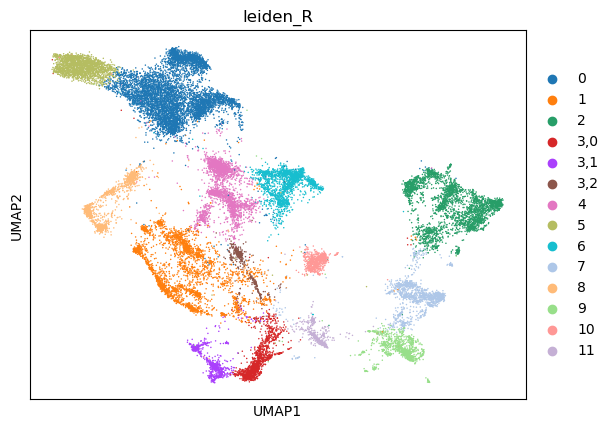

In [4]:
sc.tl.leiden(scdata, resolution= 0.2, restrict_to=['leiden',['3']])
sc.pl.umap(scdata, color = 'leiden_R')

In [19]:
count_summary(scdata, 'leiden_R', 'species')

C:\Users\sunrui\AppData\Local\Temp\ipykernel_81284\817895412.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([key_1, key_2]).size().reset_index(name='count')
C:\Users\sunrui\AppData\Local\Temp\ipykernel_81284\817895412.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby(key_2).size().reset_index(name='total_count')


species     CY    JT    M   QF     T
leiden_R                            
0         1446  1422    0    0  3359
1          973  1146  257  559   237
2         1017   892  214  711   291
3,0          0     8  420  173   704
3,1          5    12  172  450   115
3,2          7   232   54   44    61
4         1210  1037    0    0   116
5            0    10  899  412   673
6          817   903   34   12    75
7          306   528  186  108   210
8          686   592    6   17    33
9          203   234  139  196   333
10          53    38  302   23   265
11           0     5  158  151   271

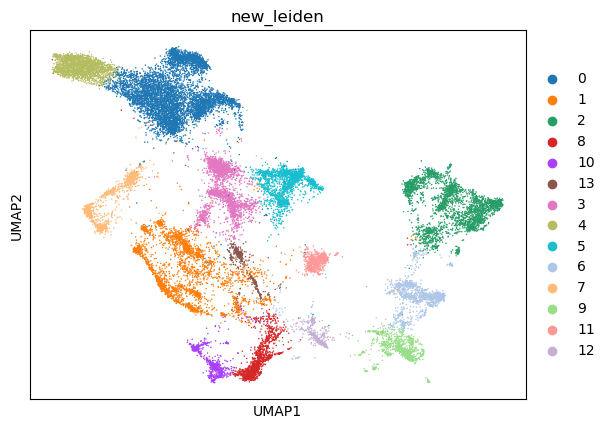

In [5]:
tmp = dict(scdata.obs.leiden_R.value_counts())

new_leiden = {}
i = 0
for key in tmp:
    new_leiden[key] = str(i)
    i += 1 

scdata.obs['new_leiden'] = scdata.obs['leiden_R'].map(new_leiden)
sc.pl.umap(scdata, color = 'new_leiden')

In [26]:
mdata

AnnData object with n_obs × n_vars = 2841 × 2670
    obs: 'species', 'tissues', 'samples', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cluster', 'celltype', 'coarse_celltype', 'eco', 'leiden_R', 'new_leiden', 'pred_label', 'celltype_vis'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'eco_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'species_colors', 'umap', 'leiden_R', 'leiden_R_colors', 'new_leiden_colors', 'pred_label_colors', 'celltype_vis_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

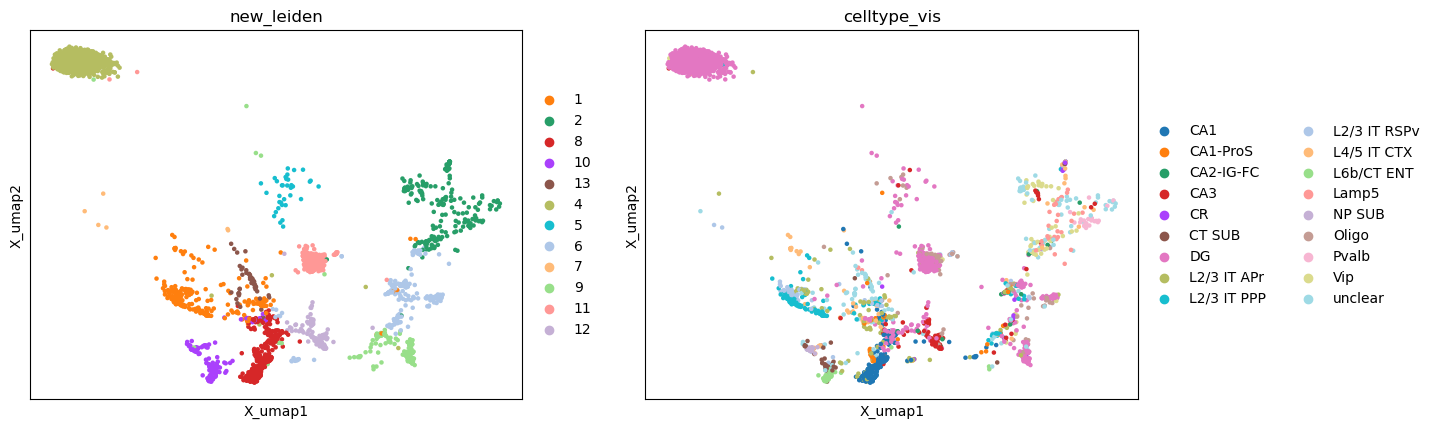

In [29]:
#mdata = scdata[scdata.obs.species =='M']
del mdata.uns['celltype_vis_colors']
mdata.obs.drop(columns = 'celltype_vis', inplace = True)

pred_class_label = mhm_anno.loc[:,'pred_label']

mdata.obs.loc[:,'pred_label'] = pred_class_label

coarse_dic = {}
for celltype, counts in mdata.obs.pred_label.value_counts().items():
    if counts >= 20:
        coarse_dic[celltype] = celltype
    else: 
        coarse_dic[celltype] = 'unclear'
mdata.obs.loc[:,'celltype_vis'] = mdata.obs.pred_label.map(coarse_dic)



sc.pl.embedding(mdata, basis = 'X_umap', color = ['new_leiden','celltype_vis'])

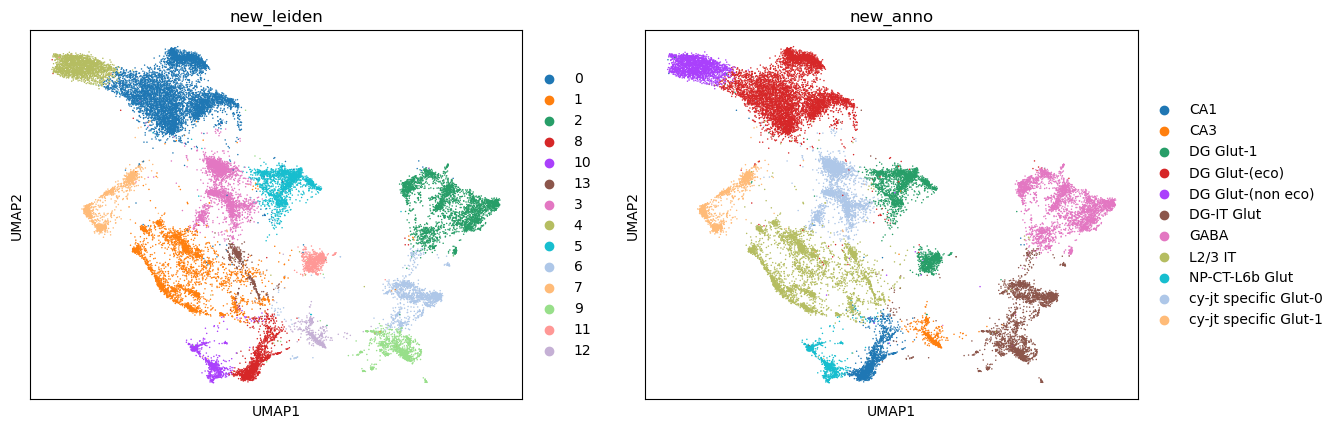

In [6]:
new_anno_dic = {'0': 'DG Glut-(eco)',
                '1': 'L2/3 IT', # 这个橙色cluster看起来主要有 L2/3 IT PPP 和 L2/3 IT RSPv
                '2': 'GABA', # 这个绿色cluster 里面可以看到Pvalb 和Lamp5 这个都是抑制性neuron
                '3': 'cy-jt specific Glut-0',
                '8': 'CA1', 
                '10': 'NP-CT-L6b Glut',  # 10这个cluster 里面可以看到 左上是NP SUB 棕色 是CT SUB 右下浅绿是L6b/CT ENT，和先前命名一致
                '13': 'L2/3 IT',  # 这个决定和cluster 1（橙色）一致
                '4': 'DG Glut-(non eco)', # 暂时先这样命名，方便区分 0-4
                '5': 'DG Glut-1',  # 这个看起来就是DG， 和 cluster 11 一致
                '6': 'DG-IT Glut', # cluster 6,9 看起来主要有DG 和 L2/3 IT,所以统一命名成 DG-IT Glut
                '7': 'cy-jt specific Glut-1',
                '9': 'DG-IT Glut',
                '11': 'DG Glut-1',
                '12': 'CA3'}

scdata.obs.loc[:,'new_anno'] = scdata.obs.new_leiden.map(new_anno_dic)
sc.pl.umap(scdata, color = ['new_leiden','new_anno'])

In [7]:
scdata.write_h5ad('final_hvg.h5ad')

In [36]:
count_summary(scdata, 'new_leiden', 'species')

C:\Users\sunrui\AppData\Local\Temp\ipykernel_81284\817895412.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([key_1, key_2]).size().reset_index(name='count')
C:\Users\sunrui\AppData\Local\Temp\ipykernel_81284\817895412.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby(key_2).size().reset_index(name='total_count')


species       CY    JT    M   QF     T
new_leiden                            
0           1446  1422    0    0  3359
1            973  1146  257  559   237
2           1017   892  214  711   291
8              0     8  420  173   704
10             5    12  172  450   115
13             7   232   54   44    61
3           1210  1037    0    0   116
4              0    10  899  412   673
5            817   903   34   12    75
6            306   528  186  108   210
7            686   592    6   17    33
9            203   234  139  196   333
11            53    38  302   23   265
12             0     5  158  151   271

In [41]:
print(scdata.shape)
drop_id_1 = np.logical_and(scdata.obs.new_leiden == '3', scdata.obs.species == 'T')
drop_id_2 = np.logical_and(scdata.obs.new_leiden == '7', scdata.obs.species.isin(['M','QF','T']))
print(drop_id_1.sum(),drop_id_2.sum())

drop_id = np.logical_or(drop_id_1,drop_id_2)
print(drop_id.sum())

scdata = scdata[~drop_id,:]
print(scdata.shape)
count_summary(scdata, 'new_leiden', 'species')

(26222, 2670)
116 56
172
(26050, 2670)


C:\Users\sunrui\AppData\Local\Temp\ipykernel_81284\817895412.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([key_1, key_2]).size().reset_index(name='count')
C:\Users\sunrui\AppData\Local\Temp\ipykernel_81284\817895412.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby(key_2).size().reset_index(name='total_count')


species       CY    JT    M   QF     T
new_leiden                            
0           1446  1422    0    0  3359
1            973  1146  257  559   237
2           1017   892  214  711   291
8              0     8  420  173   704
10             5    12  172  450   115
13             7   232   54   44    61
3           1210  1037    0    0     0
4              0    10  899  412   673
5            817   903   34   12    75
6            306   528  186  108   210
7            686   592    0    0     0
9            203   234  139  196   333
11            53    38  302   23   265
12             0     5  158  151   271

### 导入小鼠注释完毕

C:\Users\sunrui\AppData\Local\Temp\ipykernel_81284\2359644345.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['IT-ET Glut-0' 'cy-jt specific Glut-0' 'IT-ET Glut-0' ...
 'DG-IMN Glut-(eco)' 'DG-IMN Glut-(eco)' 'DG-IMN Glut-(eco)']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  scdata.obs.loc[:,'new_anno'] = scdata.obs.new_leiden.map(new_anno_dic)


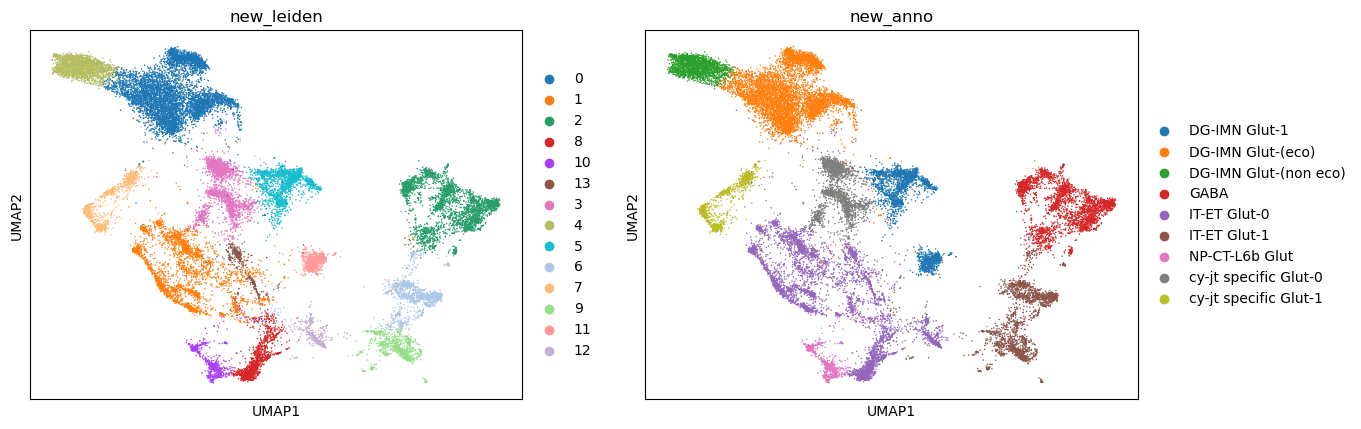

In [47]:
new_anno_dic = {'0': 'DG-IMN Glut-(eco)',
                '1': 'IT-ET Glut-0',
                '2': 'GABA',
                '3': 'cy-jt specific Glut-0',
                '8': 'IT-ET Glut-0', 
                '10': 'NP-CT-L6b Glut',
                '13': 'IT-ET Glut-0', 
                '4': 'DG-IMN Glut-(non eco)',
                '5': 'DG-IMN Glut-1',
                '6': 'IT-ET Glut-1',
                '7': 'cy-jt specific Glut-1',
                '9': 'IT-ET Glut-1',
                '11': 'DG-IMN Glut-1',
                '12': 'IT-ET Glut-0'}
scdata.obs.loc[:,'new_anno'] = scdata.obs.new_leiden.map(new_anno_dic)
sc.pl.umap(scdata, color = ['new_leiden','new_anno'])

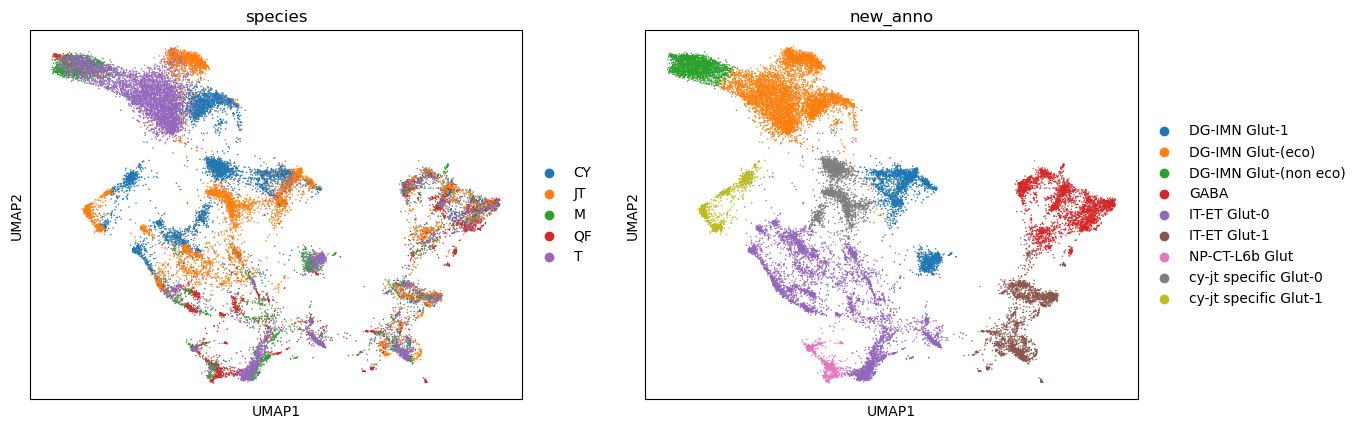

In [48]:
sc.pl.umap(scdata, color = ['species','new_anno'])

## 分隔

## 之前的分析 暂时不用

In [2]:
save_dir = 'data'
scdata = sc.read_h5ad(os.path.join(save_dir, 'hmdata_raw_1.h5ad'))
scdata.raw = scdata

eco_dic = {'CY': 'eco',
           'JT': 'eco',
           'QF': 'non-eco',
           'M': 'non-eco',
           'T': 'eco'}

scdata.obs.loc[:,'eco'] = scdata.obs.species.map(eco_dic)


sc.tl.rank_genes_groups(scdata, 'eco', method='wilcoxon')

deg_df = pd.DataFrame(scdata.uns['rank_genes_groups']['names'])

sel_gene = np.concatenate([deg_df.iloc[:1000,0].values, deg_df.iloc[:1000,1].values])
sel_gene = np.unique(sel_gene)
print(sel_gene.shape)

sc.pp.highly_variable_genes(scdata, n_top_genes=1000)
hvg = scdata.var.index.values[scdata.var.highly_variable]

sel_gene = np.concatenate([hvg, sel_gene])
sel_gene = np.unique(sel_gene)
print(sel_gene.shape)

neuron = scdata[scdata.obs.cluster == 'neuron']
neuron = neuron[:,sel_gene]
print(neuron.shape)

(2000,)
(2670,)
(26567, 2670)


In [3]:

def pipe_1(scdata, sigma = 0.1, theta = 1.5, regular = True):
    if regular:
        sc.tl.pca(scdata)
        sc.pl.pca(scdata, color = ['species', 'celltype'])
        sc.pp.neighbors(scdata)
        sc.tl.umap(scdata)
        sc.pl.umap(scdata, color = ['species', 'celltype'])
    sce.pp.harmony_integrate(scdata, 'species', max_iter_harmony = 20, sigma = sigma, random_state = 0,theta = theta)#theta = 2)
    sc.pl.embedding(scdata, basis = 'X_pca_harmony', color = ['species','celltype'])
    sc.pp.neighbors(scdata, use_rep= 'X_pca_harmony')
    sc.tl.umap(scdata)
    sc.pl.umap(scdata, color = ['species','celltype'])

    eco_dic = {'CY': 'eco',
            'JT': 'eco',
            'QF': 'non-eco',
            'M': 'non-eco',
            'T': 'eco'}

    scdata.obs.loc[:,'eco'] = scdata.obs.species.map(eco_dic)
    sc.pl.umap(scdata, color = 'eco')
    return scdata 

def count_summary(neuron, key_1 , key_2 = 'samples'):
        anno_df = neuron.obs.copy()
        anno_df.head()

        df = anno_df 
        # 1. 按col1和col2分组，统计每个组合的数量
        grouped = df.groupby([key_1, key_2]).size().reset_index(name='count')

        # 2. 按col1分组，计算总数
        total_counts = df.groupby(key_2).size().reset_index(name='total_count')

        # 3. 合并数据，计算比例
        merged = grouped.merge(total_counts, on=key_2)
        merged['proportion'] = merged['count'] #/ merged['total_count']

        # 4. 重新排序和格式化结果
        result = merged[[key_2, key_1, 'proportion']]

        result = result.pivot(index=key_1, columns=key_2, values='proportion')
        return result

print('utils code')

utils code


d:\Anaconda\envs\scanpy-1.10\lib\site-packages\scanpy\preprocessing\_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


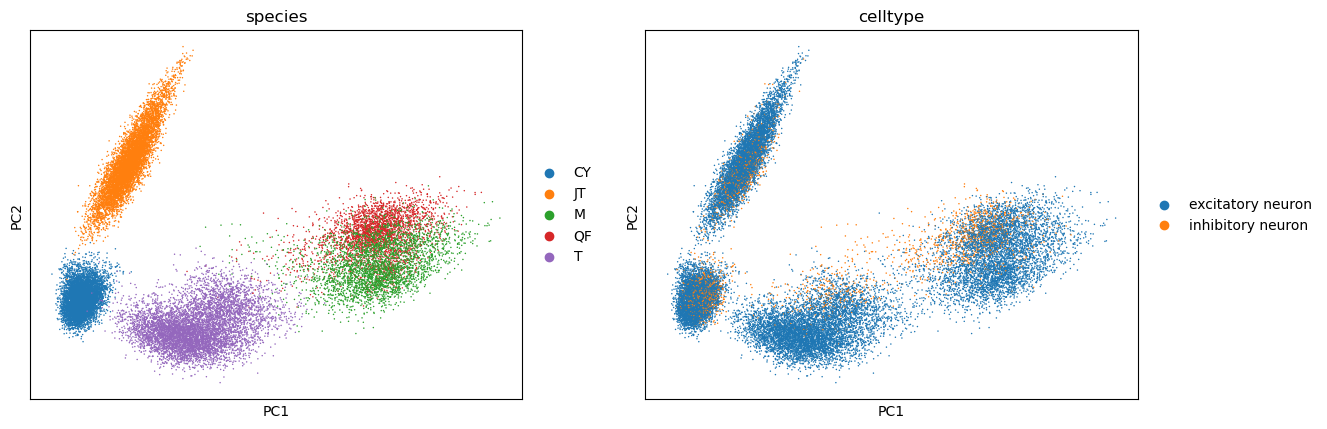

d:\Anaconda\envs\scanpy-1.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


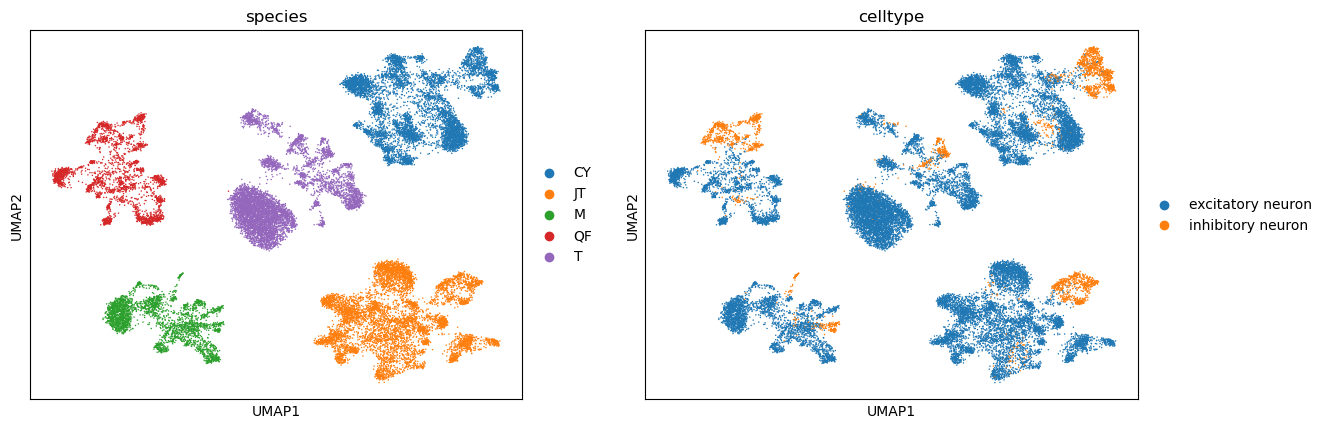

2024-12-18 13:49:39,552 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-18 13:49:42,909 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-18 13:49:43,178 - harmonypy - INFO - Iteration 1 of 20
2024-12-18 13:49:53,003 - harmonypy - INFO - Iteration 2 of 20
2024-12-18 13:50:02,778 - harmonypy - INFO - Converged after 2 iterations


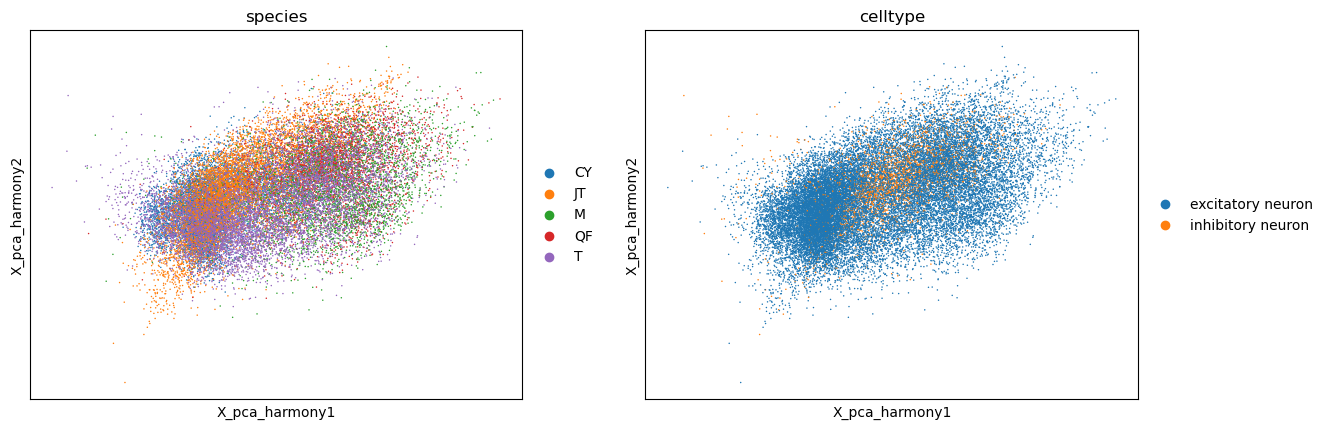

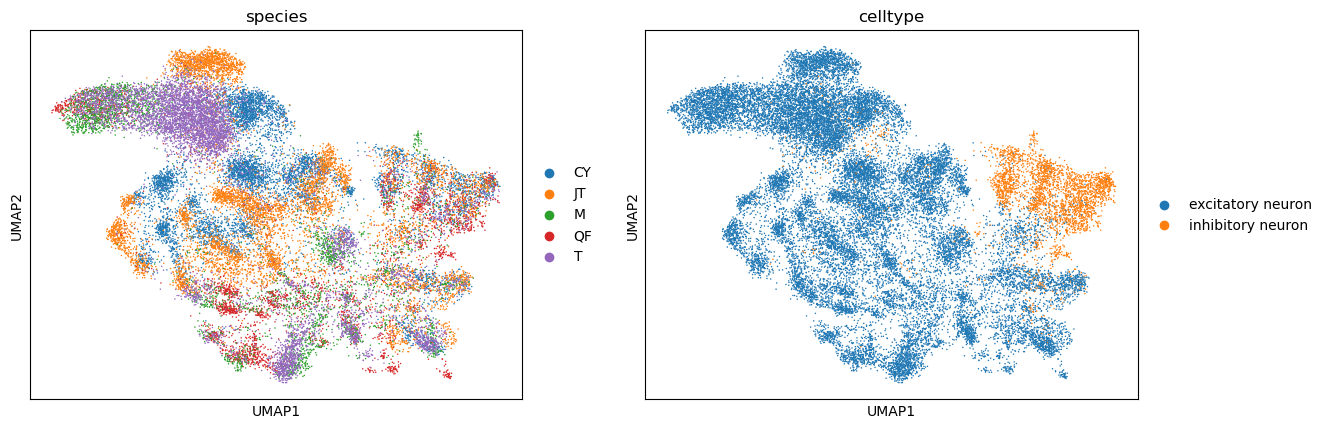

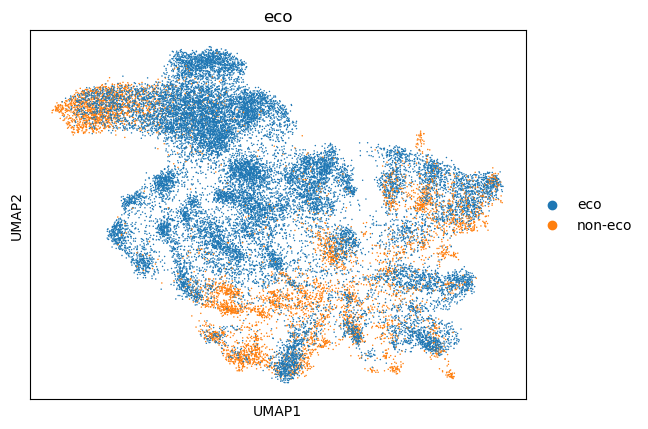

C:\Users\sunrui\AppData\Local\Temp\ipykernel_14080\2012969562.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(neuron, resolution= 0.5)


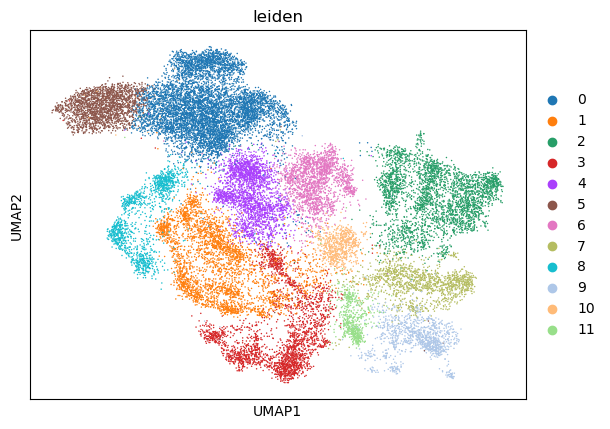

samples  CYHM  JTHM  MHM  QFHM   THM
leiden                              
0        1446  1422  249    76  3359
1         973  1146  257   559   237
2        1017   892  214   711   291
3          12   252  646   667   880
4        1210  1037    7    13   116
5           0    10  899   412   673
6         817   903   34    12    75
7         306   528  186   108   210
8         686   592    6    17    33
9         203   234  139   196   333
10         53    38  302    23   265
11          0     5  158   151   271


C:\Users\sunrui\AppData\Local\Temp\ipykernel_14080\3895147484.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([key_1, key_2]).size().reset_index(name='count')
C:\Users\sunrui\AppData\Local\Temp\ipykernel_14080\3895147484.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby(key_2).size().reset_index(name='total_count')


In [4]:
neuron = pipe_1(neuron, 0.1, 2.2,True)
sc.tl.leiden(neuron, resolution= 0.5)
sc.pl.umap(neuron, color = 'leiden')
print(count_summary(neuron, 'leiden' , key_2 = 'samples'))

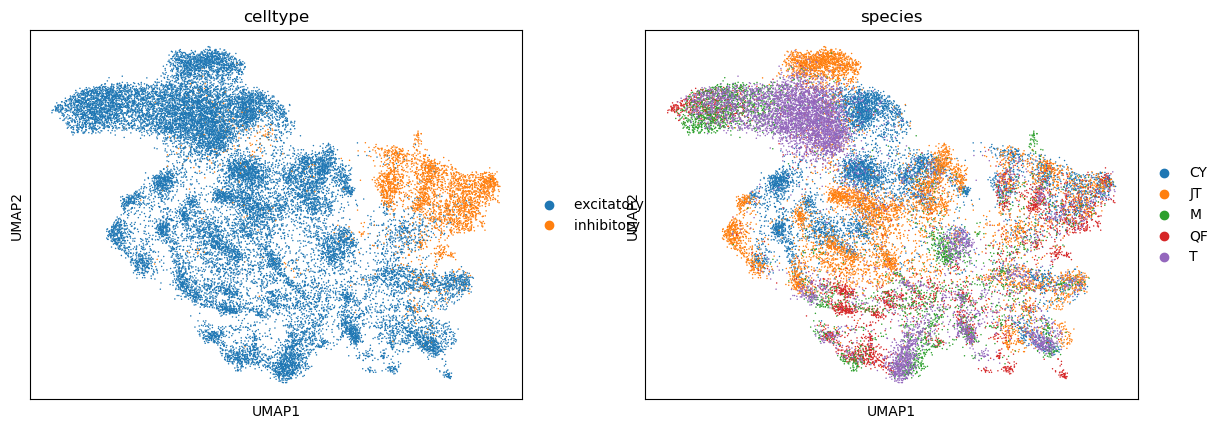

In [5]:
sc.pl.umap(neuron, color = ['celltype','species'])

In [6]:
count_summary(neuron, 'leiden', 'species')

C:\Users\sunrui\AppData\Local\Temp\ipykernel_14080\3895147484.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([key_1, key_2]).size().reset_index(name='count')
C:\Users\sunrui\AppData\Local\Temp\ipykernel_14080\3895147484.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby(key_2).size().reset_index(name='total_count')


species    CY    JT    M   QF     T
leiden                             
0        1446  1422  249   76  3359
1         973  1146  257  559   237
2        1017   892  214  711   291
3          12   252  646  667   880
4        1210  1037    7   13   116
5           0    10  899  412   673
6         817   903   34   12    75
7         306   528  186  108   210
8         686   592    6   17    33
9         203   234  139  196   333
10         53    38  302   23   265
11          0     5  158  151   271

345
(26222, 2670)


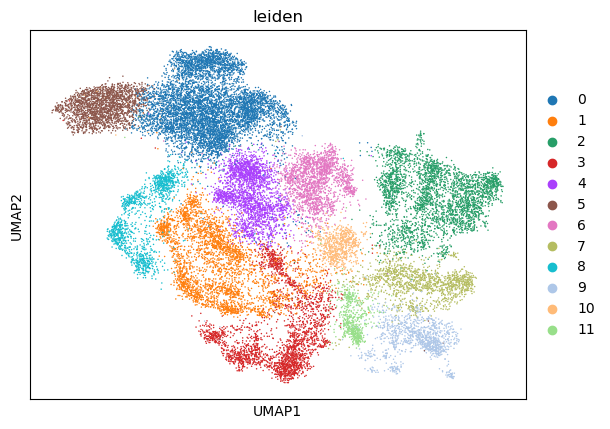

samples  CYHM  JTHM  MHM  QFHM   THM
leiden                              
0        1446  1422    0     0  3359
1         973  1146  257   559   237
2        1017   892  214   711   291
3          12   252  646   667   880
4        1210  1037    0     0   116
5           0    10  899   412   673
6         817   903   34    12    75
7         306   528  186   108   210
8         686   592    6    17    33
9         203   234  139   196   333
10         53    38  302    23   265
11          0     5  158   151   271


C:\Users\sunrui\AppData\Local\Temp\ipykernel_14080\3895147484.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([key_1, key_2]).size().reset_index(name='count')
C:\Users\sunrui\AppData\Local\Temp\ipykernel_14080\3895147484.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby(key_2).size().reset_index(name='total_count')


In [8]:
drop_id_1 = np.logical_and(neuron.obs.leiden.values == '0' , neuron.obs.eco.values == 'non-eco')
drop_id_2 = np.logical_and(neuron.obs.leiden.values == '4' , neuron.obs.eco.values == 'non-eco')
drop_id = np.logical_or(drop_id_1, drop_id_2)
print(drop_id.sum())
neuron = neuron[~drop_id,:]
print(neuron.shape) 
sc.pl.umap(neuron, color = 'leiden')
print(count_summary(neuron, 'leiden' , key_2 = 'samples'))

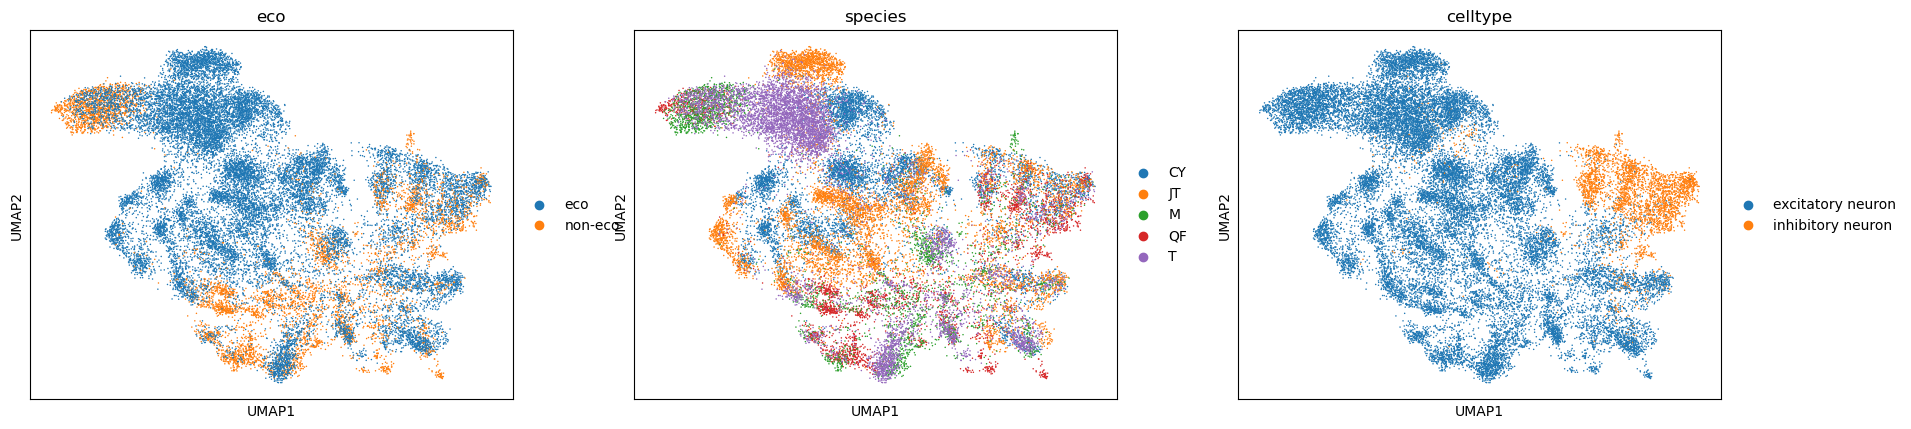

In [45]:
sc.pl.umap(neuron, color = ['eco','species','celltype'])

In [ ]:
#neuron.write('final_hvg.h5ad')

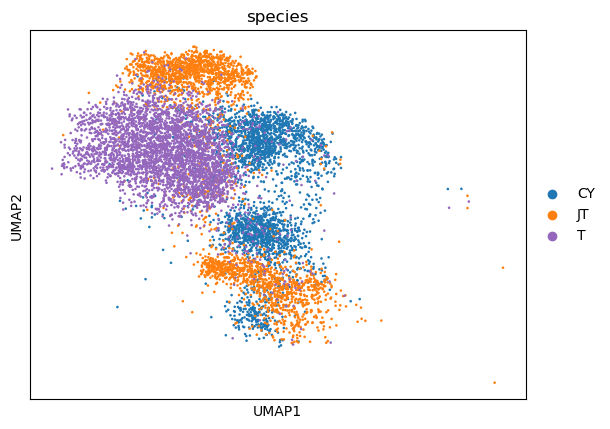

In [13]:
sub_neuron = neuron[neuron.obs.leiden.isin(['0','4'])]
sc.pl.umap(sub_neuron,color = 'species')

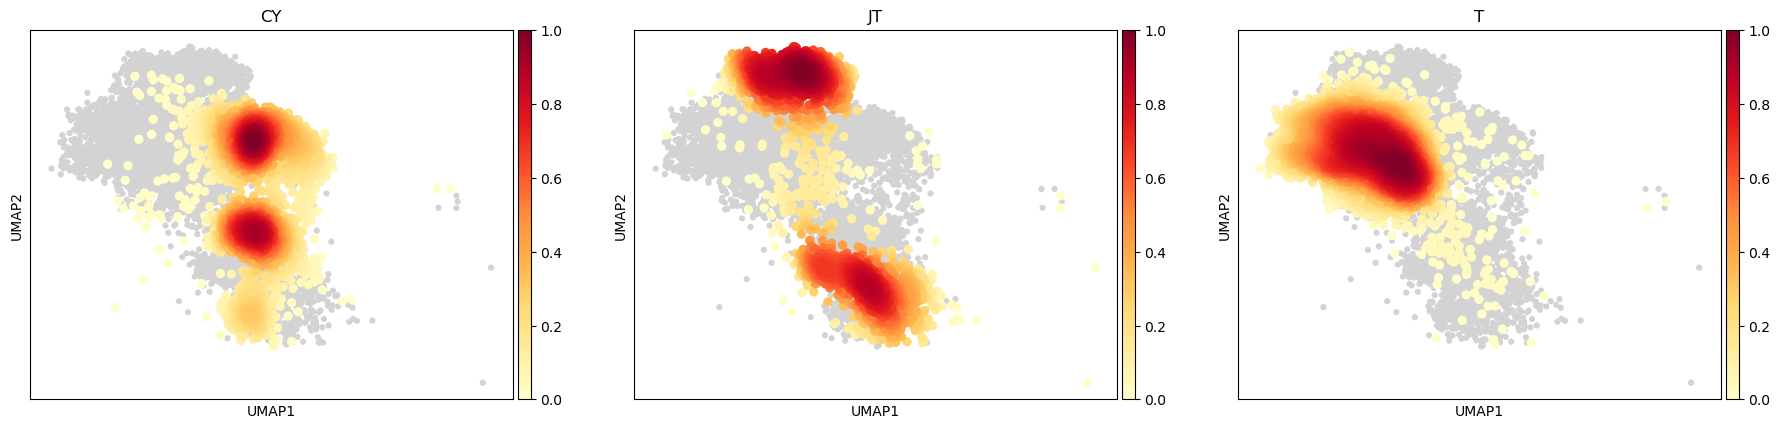

In [18]:
sc.tl.embedding_density(sub_neuron, groupby='species')
sc.pl.embedding_density(sub_neuron, basis = 'umap', key = 'umap_density_species')

## marker gene 筛选

### leiden cluster deg 筛选

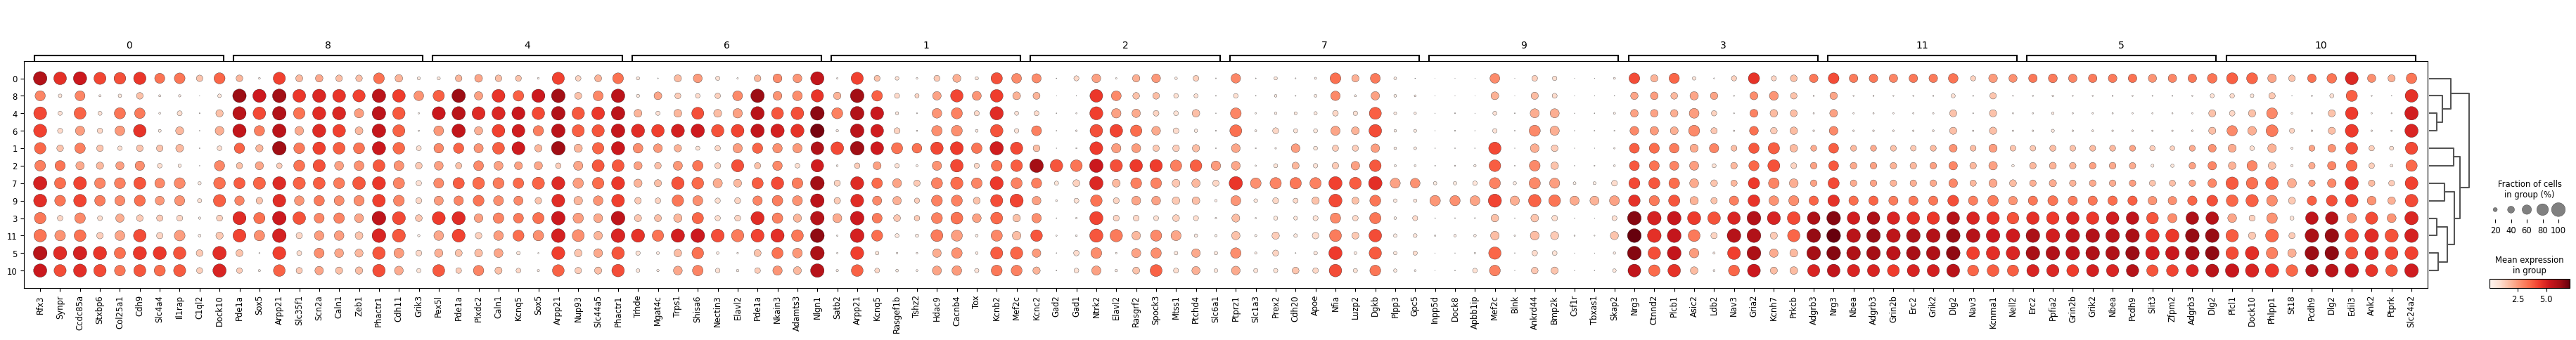

In [57]:
sc.tl.rank_genes_groups(neuron, groupby = 'leiden', use_raw=True)
sc.pl.rank_genes_groups_dotplot(neuron)

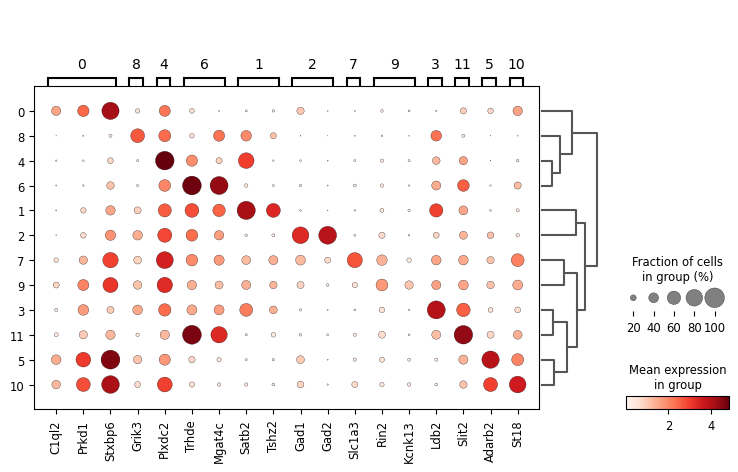

In [58]:
#sc.tl.rank_genes_groups(neuron, groupby = 'leiden', use_raw=True)
#sc.pl.rank_genes_groups_dotplot(neuron)

marker_dic = {'0':['C1ql2','Prkd1','Stxbp6'],
              '8':['Grik3'],
              '4':['Plxdc2'],
              '6': ['Trhde','Mgat4c'],
              '1': ['Satb2','Tshz2'],
              '2': ['Gad1','Gad2'],
              '7': ['Slc1a3'],
              '9':['Rin2','Kcnk13'],
              '3': ['Ldb2'],
              '11': ['Slit2'],
              '5': ['Adarb2'],
              '10': ['St18']}#['Dock8','Otof','Inpp5d','Csf1r','Blnk','Apbb1ip','Skap2','Cst3']}
sc.pl.rank_genes_groups_dotplot(neuron, var_names= marker_dic)

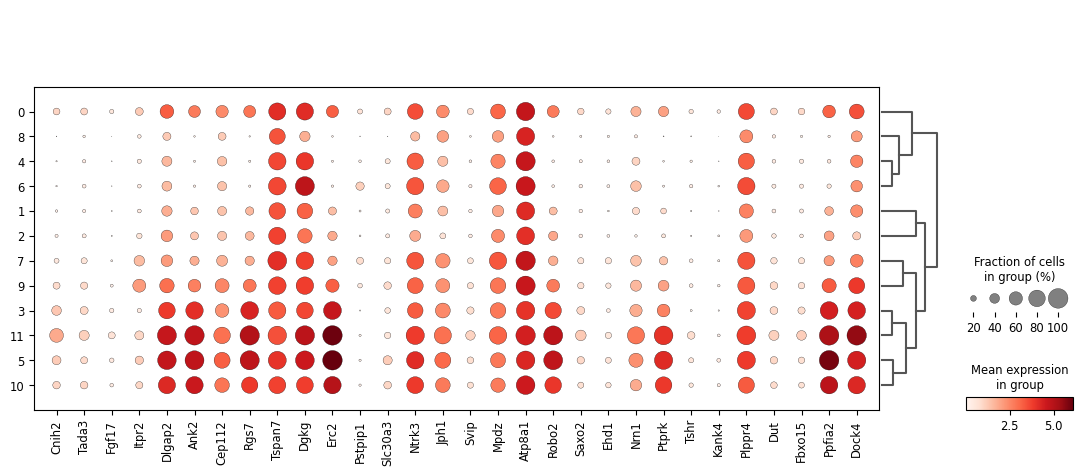

In [9]:
deg_cluster = pd.DataFrame(neuron.uns['rank_genes_groups']['names'])

#dif_cluster = neuron[neuron.obs.leiden == '11']
#sc.tl.rank_genes_groups(dif_cluster, groupby = 'eco')
sc.pl.rank_genes_groups_dotplot(neuron, var_names = deg_cluster.loc[:,'0'][80:110].values)

C:\Users\sunrui\AppData\Local\Temp\ipykernel_14080\2680823909.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['others' '4' 'others' ... '0' '0' '0']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  neuron.obs.loc[:,'diff_cluster'] = neuron.obs['leiden'].map(dif_c)


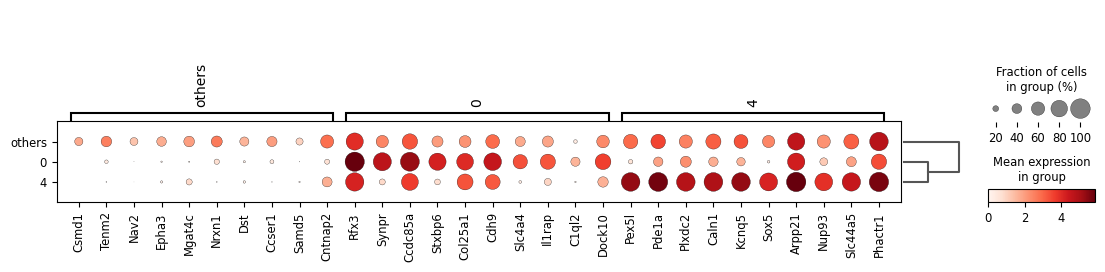

In [23]:
dif_c = {'0': '0',
         '4': '4'}
for i in range(1,12):
    if str(i) not in dif_c:
        dif_c[str(i)] = 'others'

neuron.obs.loc[:,'diff_cluster'] = neuron.obs['leiden'].map(dif_c)

sc.tl.rank_genes_groups(neuron, groupby = 'diff_cluster', use_raw=True)
sc.pl.rank_genes_groups_dotplot(neuron)

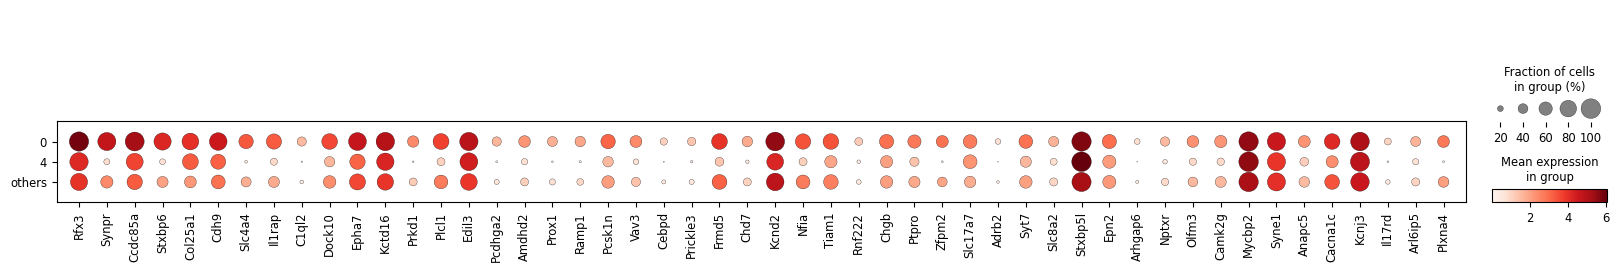

In [34]:
deg_df = pd.DataFrame(neuron.uns['rank_genes_groups']['names'])

#degs = ['C1ql3','Chd7','Slc8a2','St18','Slc4a4'] #'Frmd5'
vars_info = deg_df.loc[:,'0'][:50]
sc.pl.dotplot(neuron, var_names=vars_info, groupby='diff_cluster')

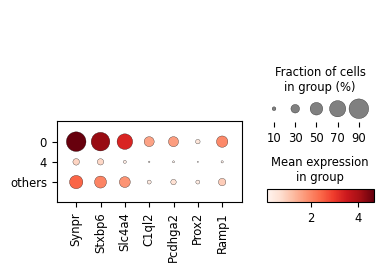

In [38]:

#cluster_0 _marker
degs_0 = ['Synpr','Stxbp6','Slc4a4','C1ql2','Pcdhga2','Prox2','Ramp1'] #'Frmd5'
sc.pl.dotplot(neuron, var_names=degs_0, groupby='diff_cluster')

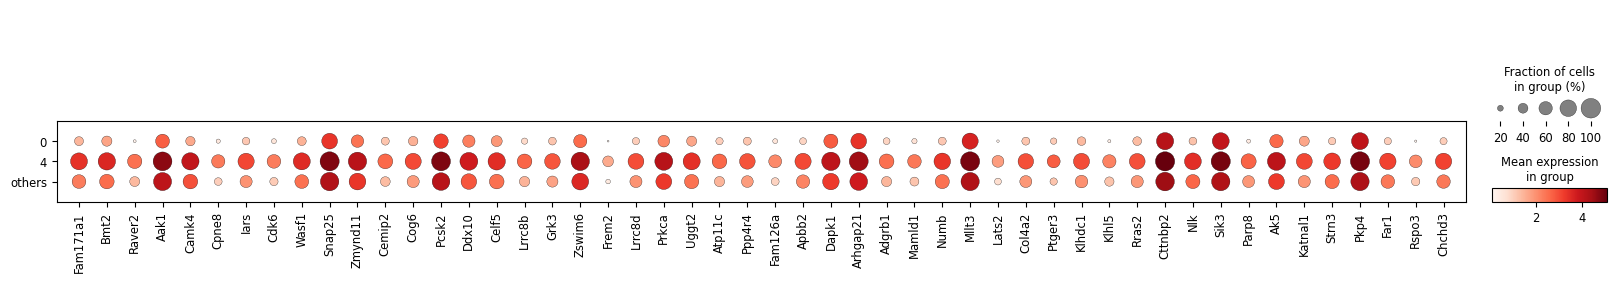

In [40]:
deg_df = pd.DataFrame(neuron.uns['rank_genes_groups']['names'])

#degs = ['C1ql3','Chd7','Slc8a2','St18','Slc4a4'] #'Frmd5'
vars_info = deg_df.loc[:,'4'][50:100]
sc.pl.dotplot(neuron, var_names=vars_info, groupby='diff_cluster')

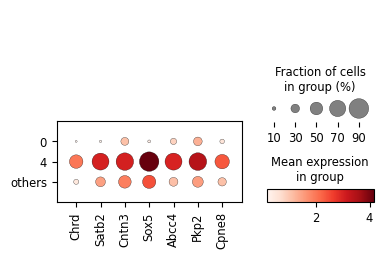

In [41]:
#cluster_4 _marker
degs_4 = ['Chrd','Satb2','Cntn3','Sox5','Abcc4','Pkp2','Cpne8'] #'Frmd5'
sc.pl.dotplot(neuron, var_names=degs_4, groupby='diff_cluster')

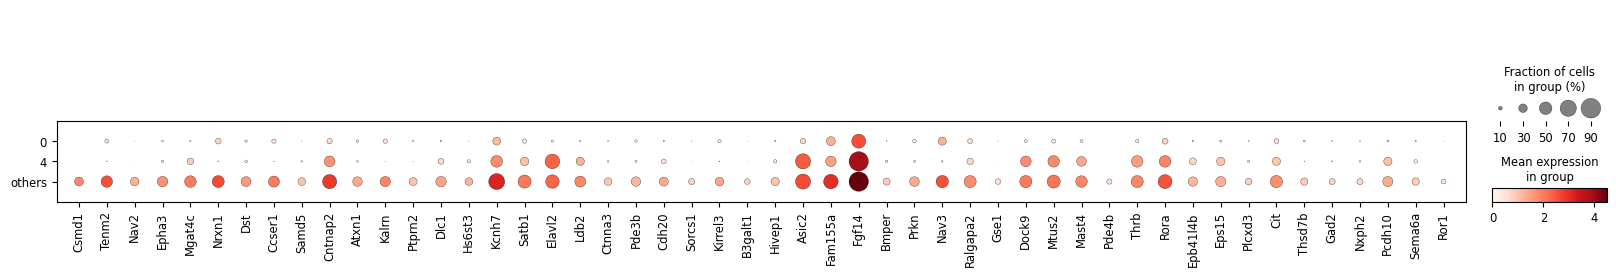

In [42]:
#degs = ['C1ql3','Chd7','Slc8a2','St18','Slc4a4'] #'Frmd5'
vars_info = deg_df.loc[:,'others'][:50]
sc.pl.dotplot(neuron, var_names=vars_info, groupby='diff_cluster')

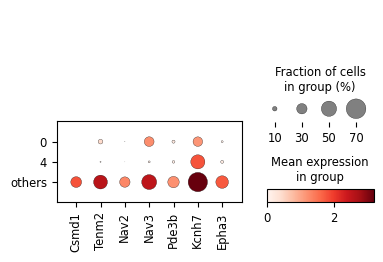

In [43]:
#cluster_other _marker
degs_other = ['Csmd1','Tenm2','Nav2','Nav3','Pde3b','Kcnh7','Epha3'] #'Frmd5'
sc.pl.dotplot(neuron, var_names=degs_other, groupby='diff_cluster')

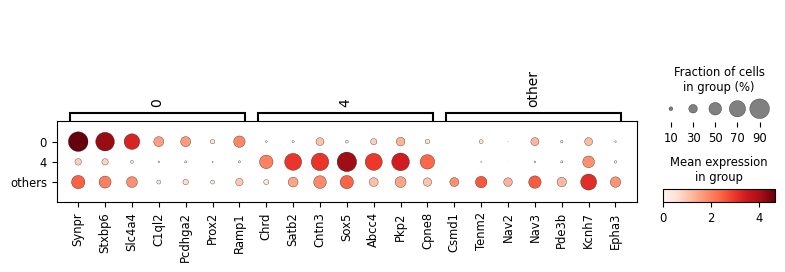

In [44]:
deg_dic = {}

deg_dic['0'] = degs_0
deg_dic['4'] = degs_4
deg_dic['other'] = degs_other 

sc.pl.dotplot(neuron, var_names=deg_dic, groupby='diff_cluster')

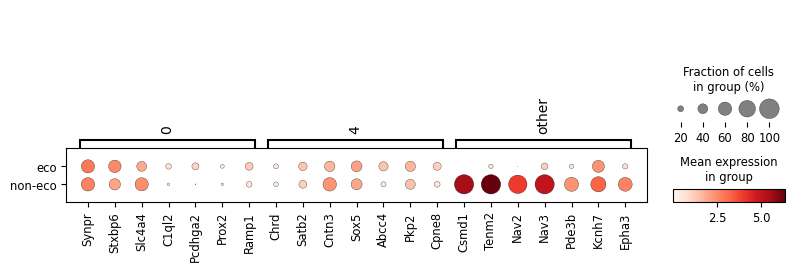

In [46]:
sc.pl.dotplot(neuron, var_names=deg_dic, groupby='eco')

categories: 0, 1, 2, etc.
var_group_labels: eco, non-eco


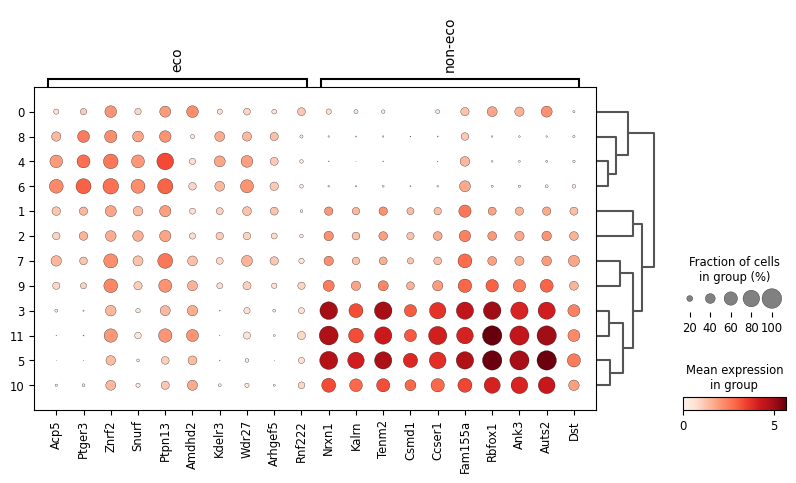

In [47]:
sc.tl.rank_genes_groups(neuron, groupby = 'eco', use_raw=True)
sc.pl.rank_genes_groups_dotplot(neuron, groupby='leiden')

categories: 0, 4, others
var_group_labels: eco, non-eco


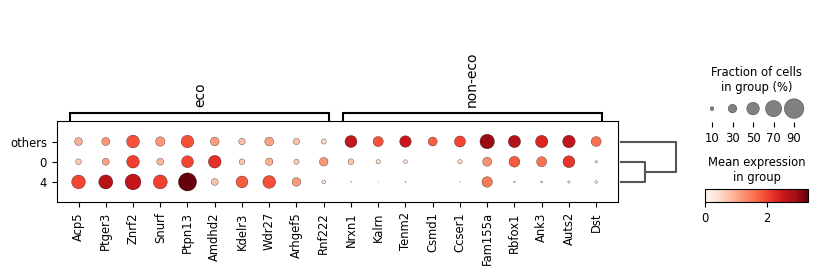

In [48]:
sc.pl.rank_genes_groups_dotplot(neuron, groupby='diff_cluster')

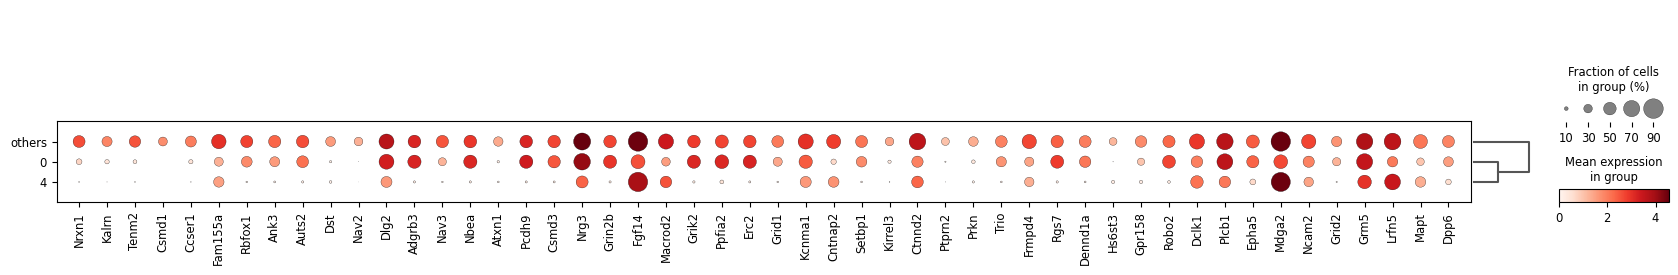

In [56]:
eco_deg = pd.DataFrame(neuron.uns['rank_genes_groups']['names'])
sc.pl.rank_genes_groups_dotplot(neuron, var_names = eco_deg.loc[:,'non-eco'][:50].values,groupby='diff_cluster')

In [54]:
eco_deg.loc[:,'eco'][50:100]

50      Efcab7
51        Mtrr
52      Hnrnpl
53     Col12a1
54      Adgrg7
55     Camsap2
56        Yaf2
57       Rnf24
58       Enpep
59       Ankar
60       Phkg1
61      Wnt10b
62     Pstpip1
63        Cog6
64       Dip2a
65        Neu3
66       Rpl35
67      Cfap36
68      Mycbp2
69      Klhl41
70      Fbxo11
71      Efcab5
72       Rep15
73      Sec61g
74     Col26a1
75    Mphosph8
76       Pgap1
77       Naa16
78      Ablim2
79       Haus7
80       Tomm7
81        Edar
82      Ccdc18
83       Micu2
84       Fanci
85      Hectd3
86       Rcvrn
87        Wif1
88      Il17rd
89       Egln1
90       Gstcd
91       Nucb1
92        Podn
93        Upp1
94       Fgf17
95     Sparcl1
96      Heatr4
97        Clgn
98       Abcc4
99        Rrp9
Name: eco, dtype: object